In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Load calibration matrix created from [Camera_Calibration](Camera_Calibration.ipynb)

In [2]:
import pickle
camera_calibration = pickle.load( open('./cam_calib_pickle.p', 'rb' ) )
mtx, dist = map(camera_calibration.get, ('mtx', 'dist'))

In [3]:
images = glob.glob('test_images/*.jpg')

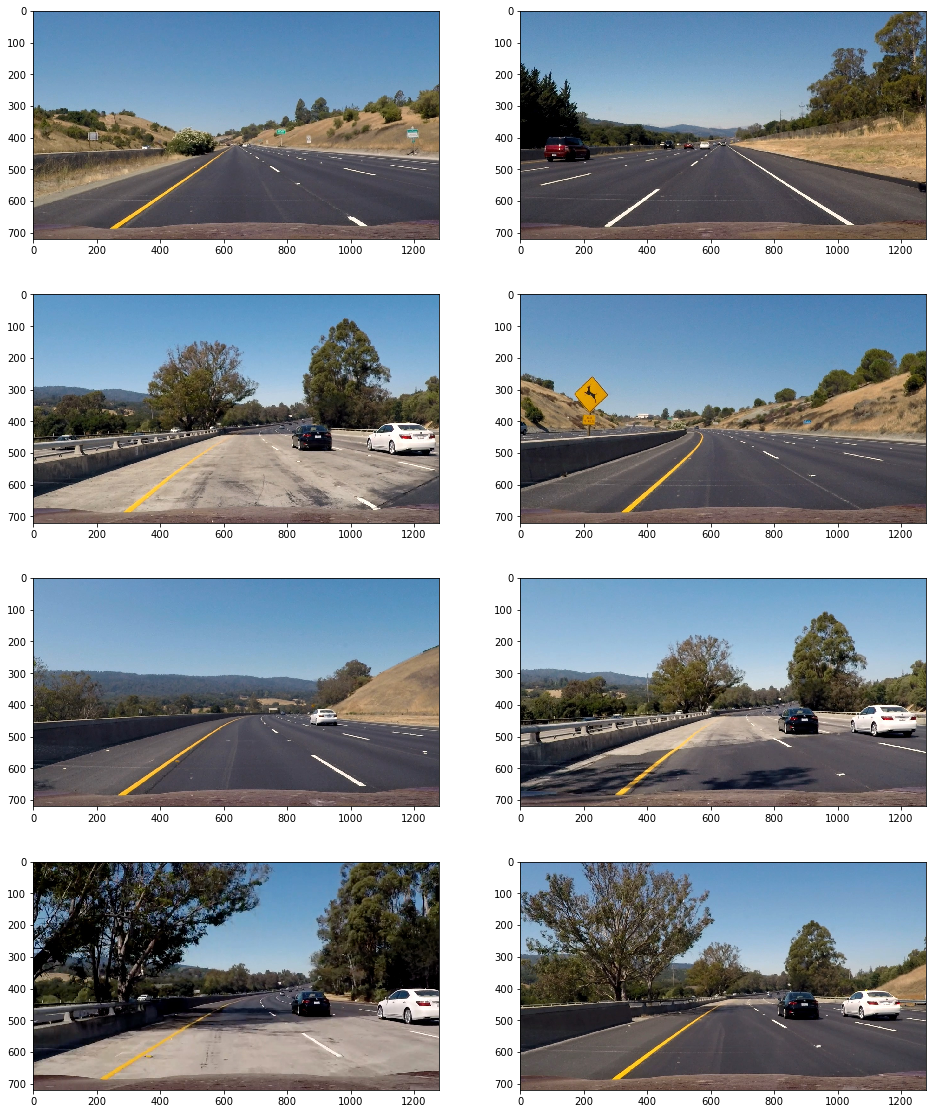

In [4]:
# Display test images
plt.figure(figsize=(16, 20))
for i, img in enumerate(images):
    img = mpimg.imread(images[i])
    plt.subplot(4, 2, i+1)
    plt.imshow(img)

In [5]:
def undistort(img, mtx = mtx, dist = dist):
    dst = cv2.cvtColor(cv2.undistort(img, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB)
    return dst

In [6]:
# Undistort images
original = []
undistort_images = []
for fname in images:
    img = cv2.imread(fname)
    original.append(img)
    dst = undistort(img)
    undistort_images.append(dst)

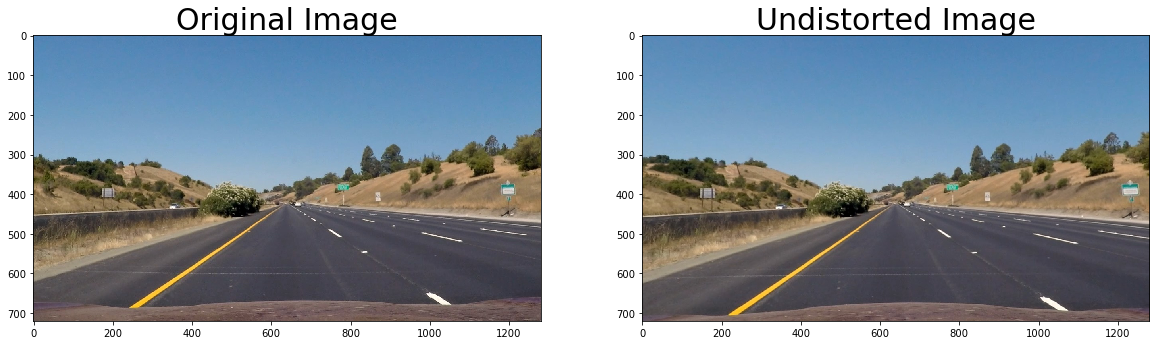

In [7]:
# Visualize undistortion
img = original[0]    
img_size = (img.shape[1], img.shape[0])

dst = undistort_images[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
def color_gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    '''
    detect lines using color and gradient
    '''
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

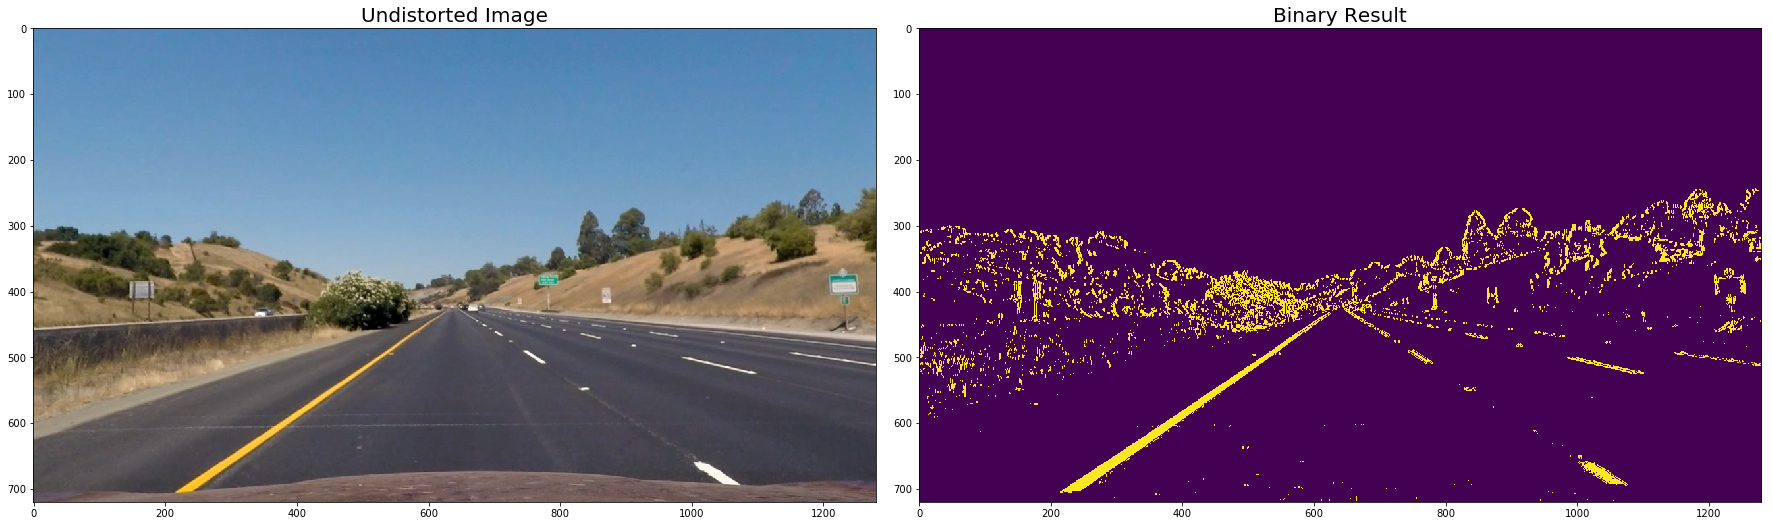

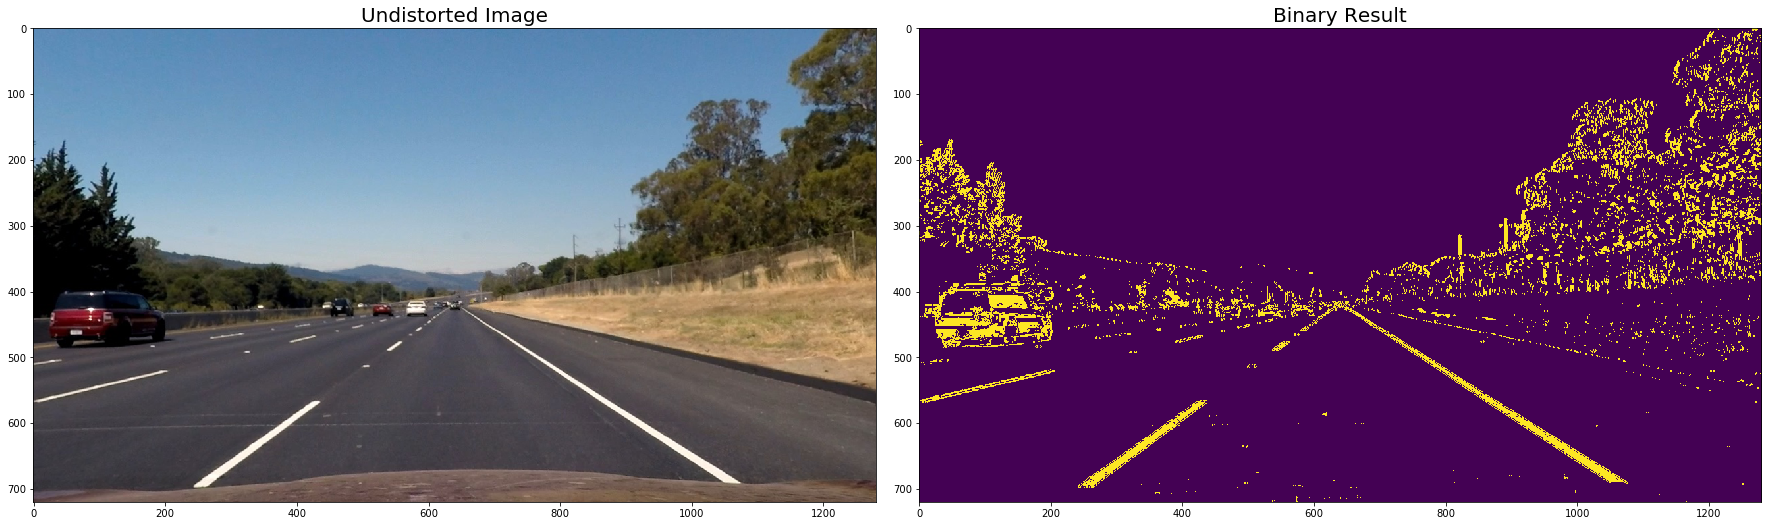

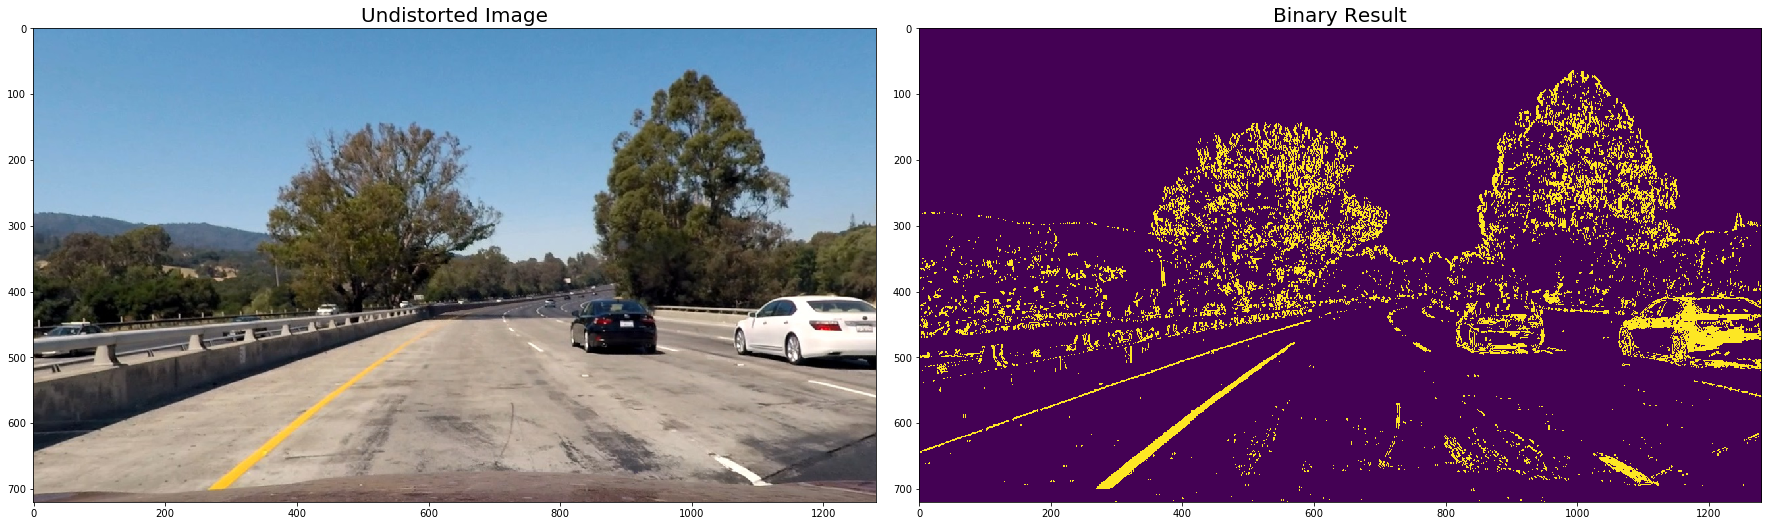

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


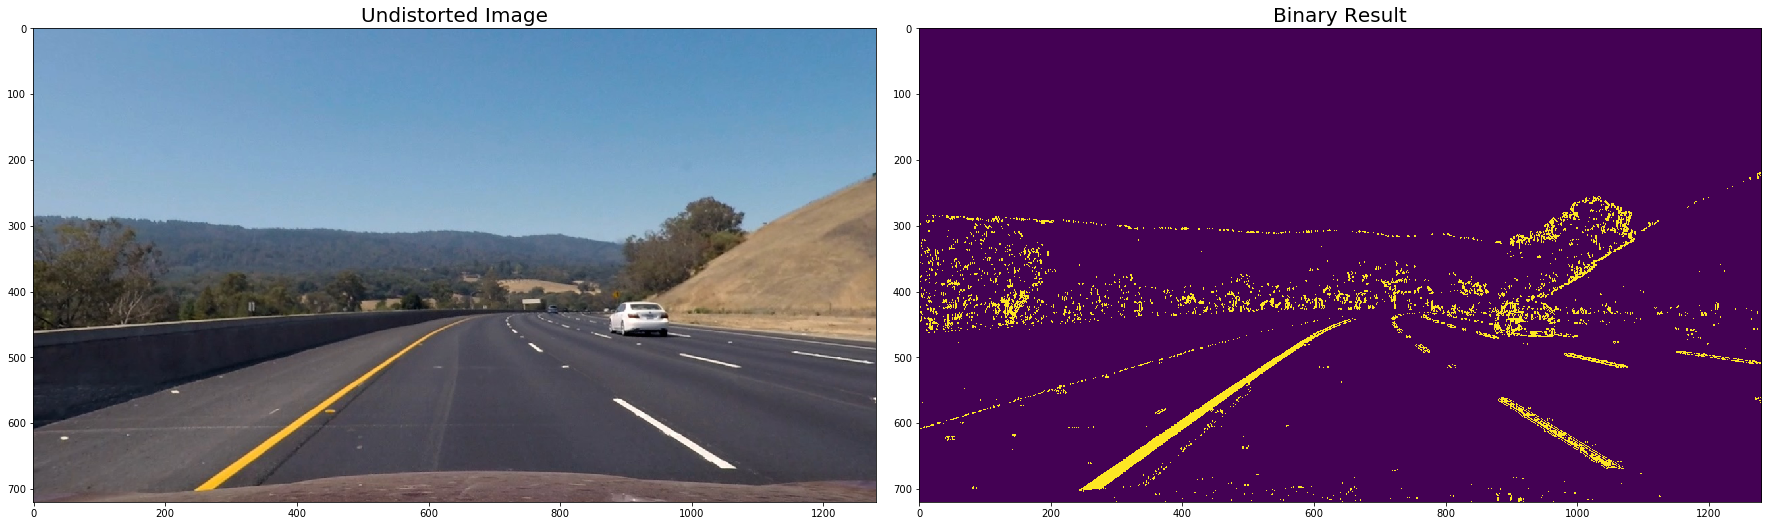

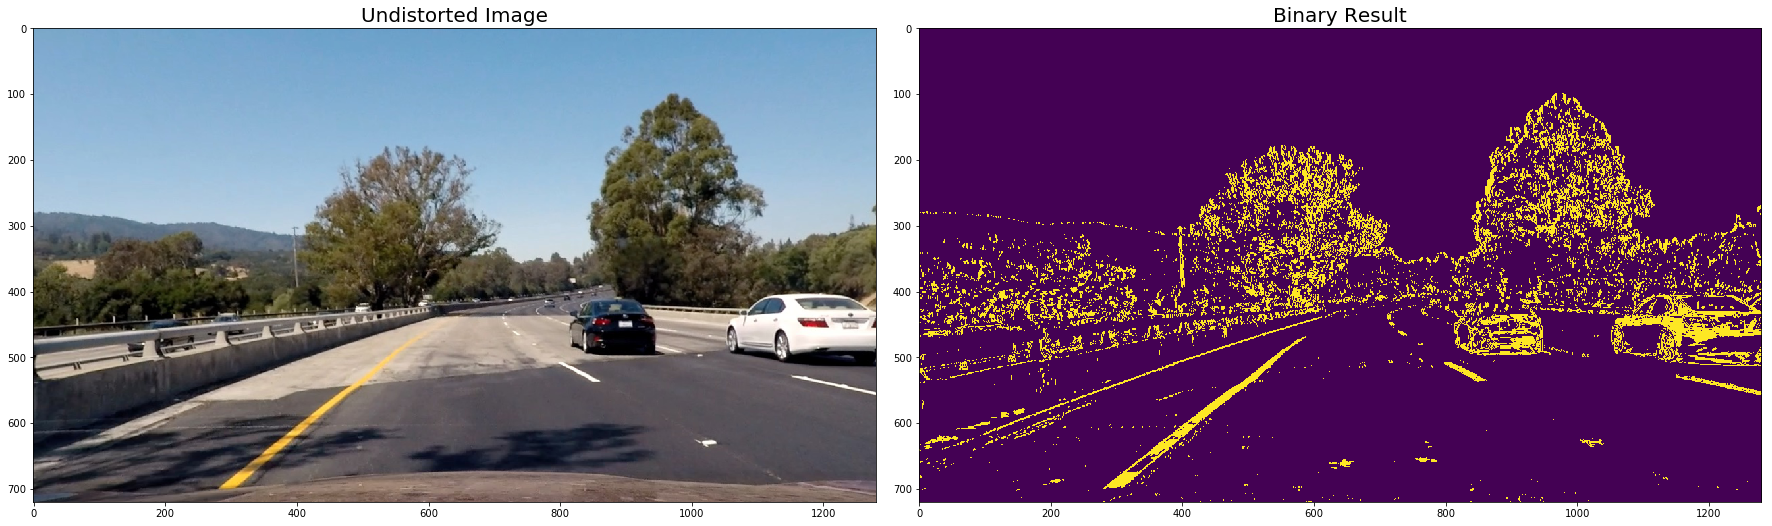

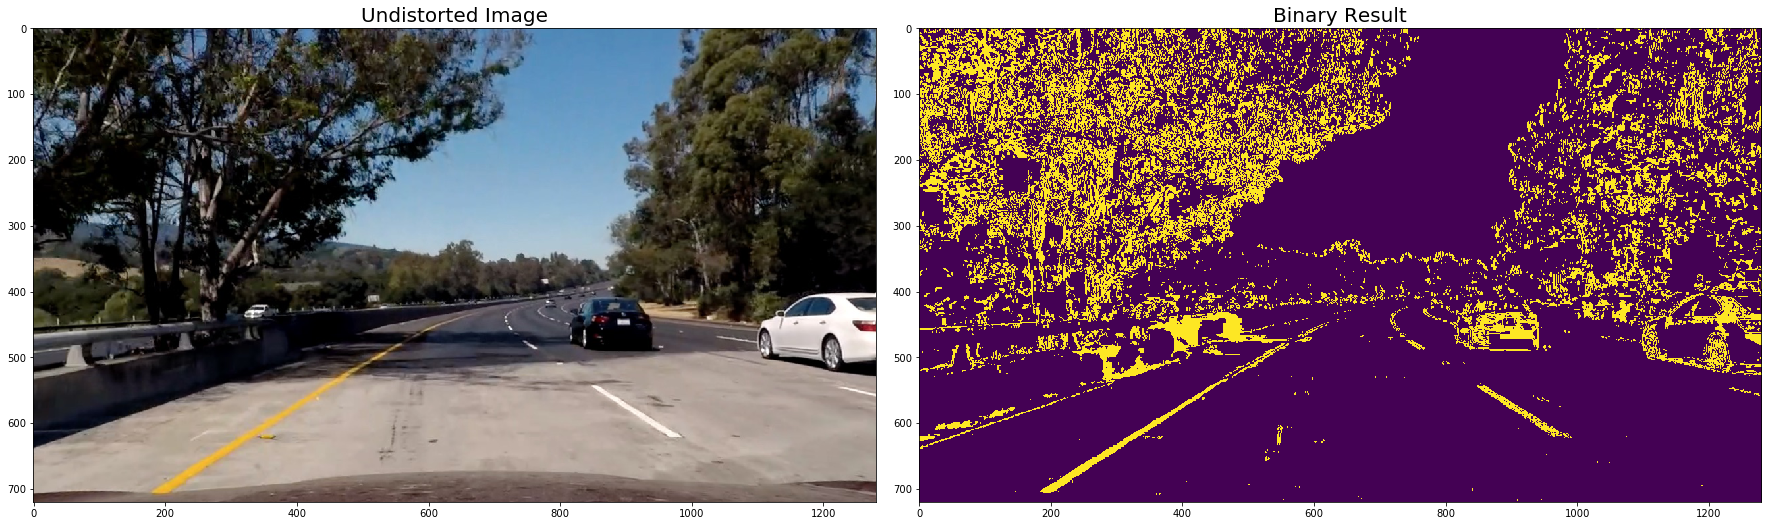

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [9]:
color_gradient_results = []
for image in undistort_images:
    result = color_gradient(image)
    color_gradient_results.append(result)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Undistorted Image', fontsize=20)

    ax2.imshow(result)
    ax2.set_title('Binary Result', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Apply transform matrix created from [Perspective Transform](Perspective_Transform.ipynb)

In [10]:
perspective_transform = pickle.load( open('./perspective_transform.p', 'rb' ) )
M, Minv = map(perspective_transform.get, ('M', 'Minv'))

In [11]:
def warp(img, M = M, img_size = (1280, 720)):
    '''
    Transform the perspective
    '''
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

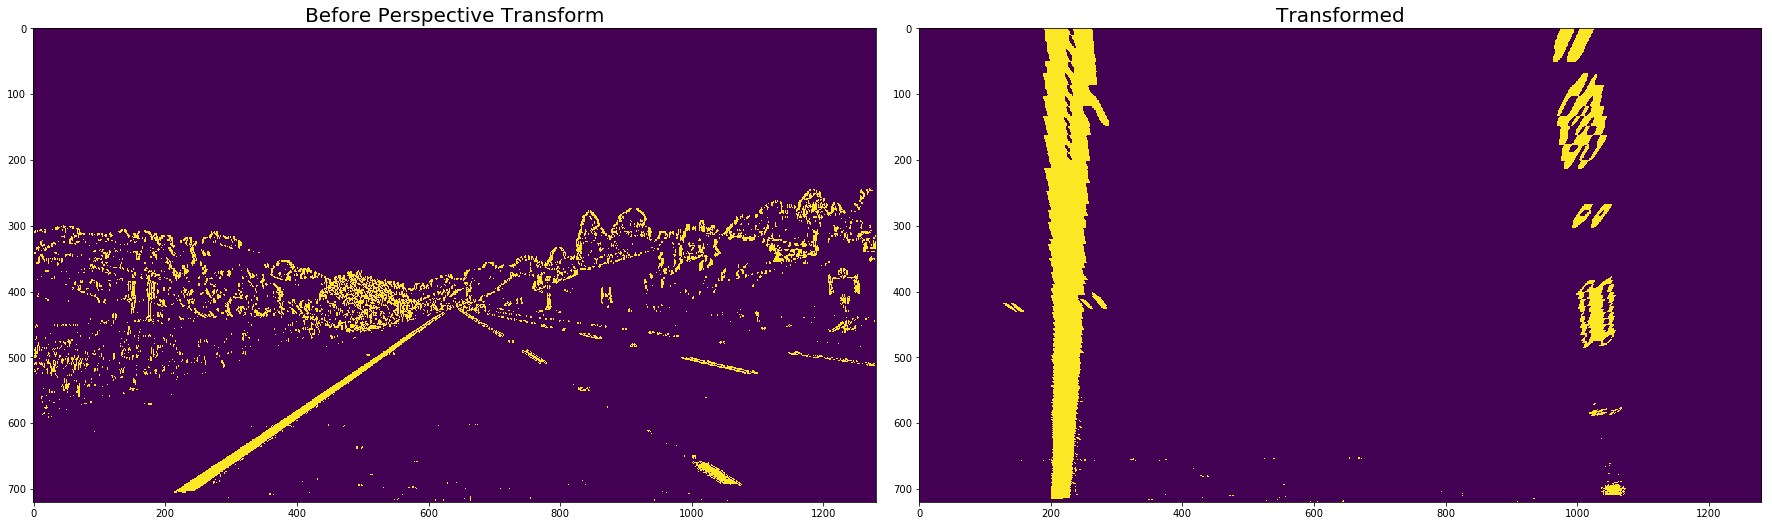

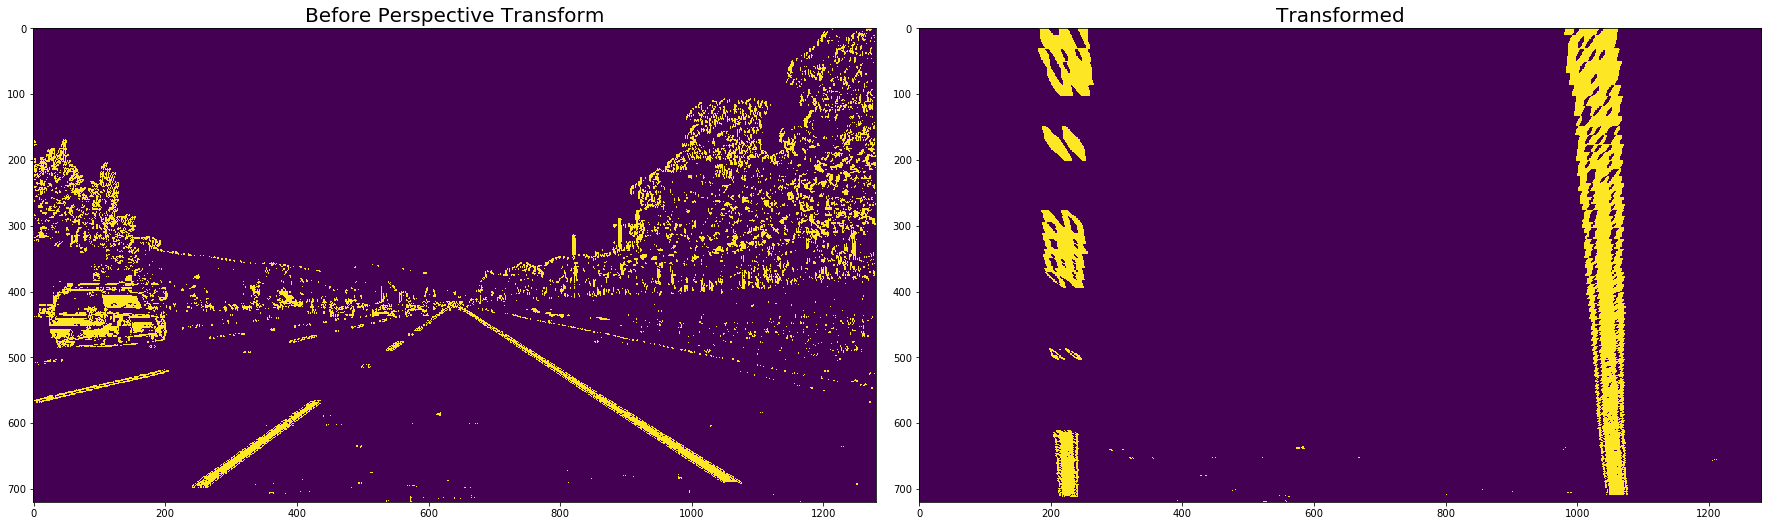

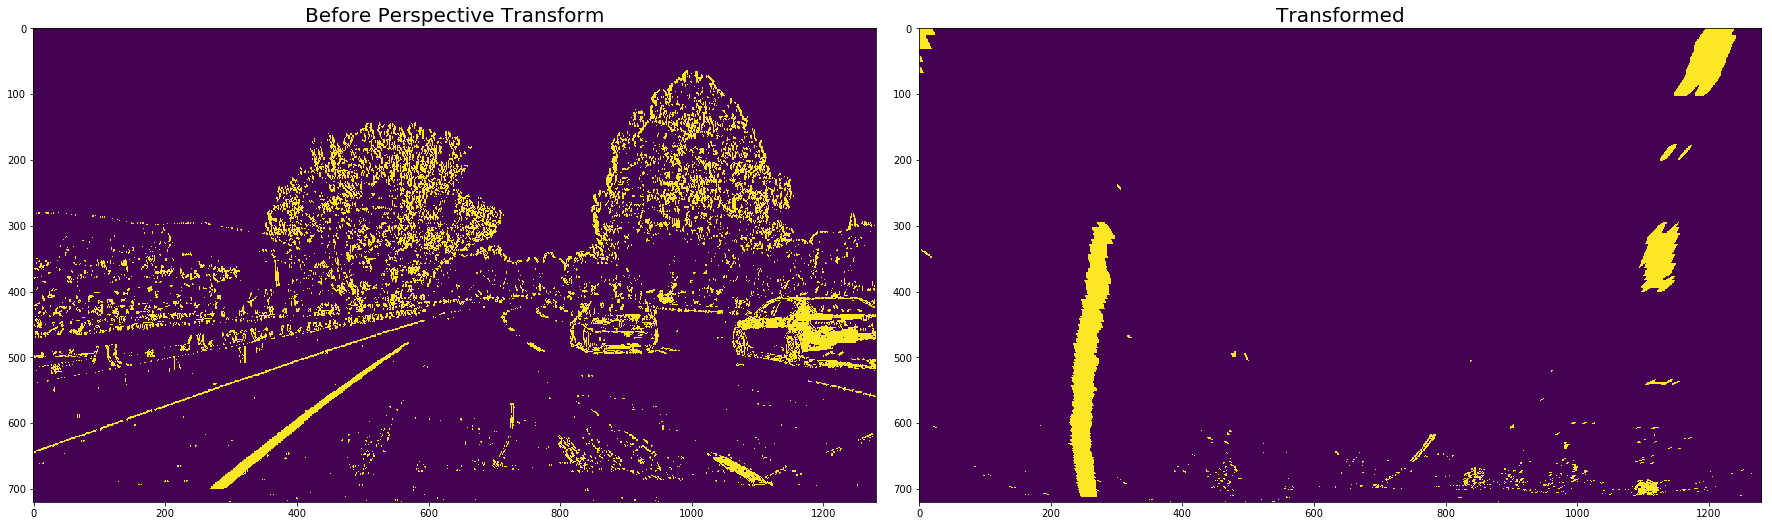

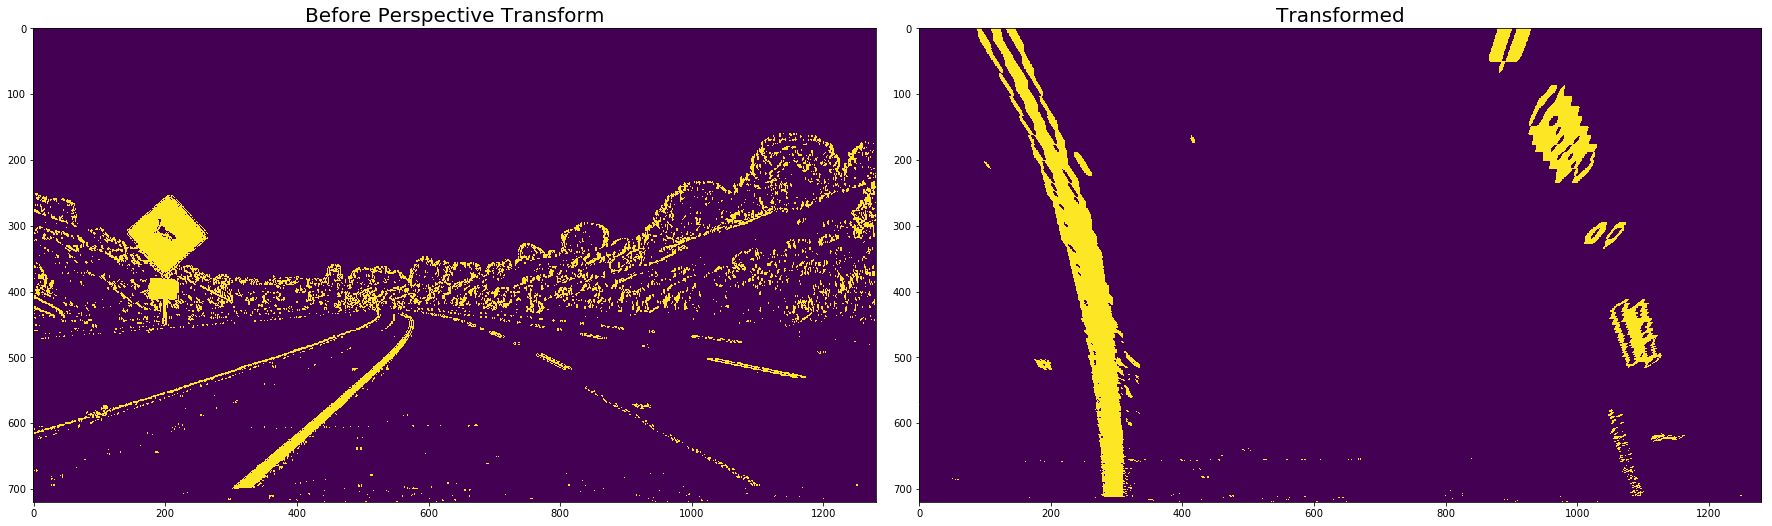

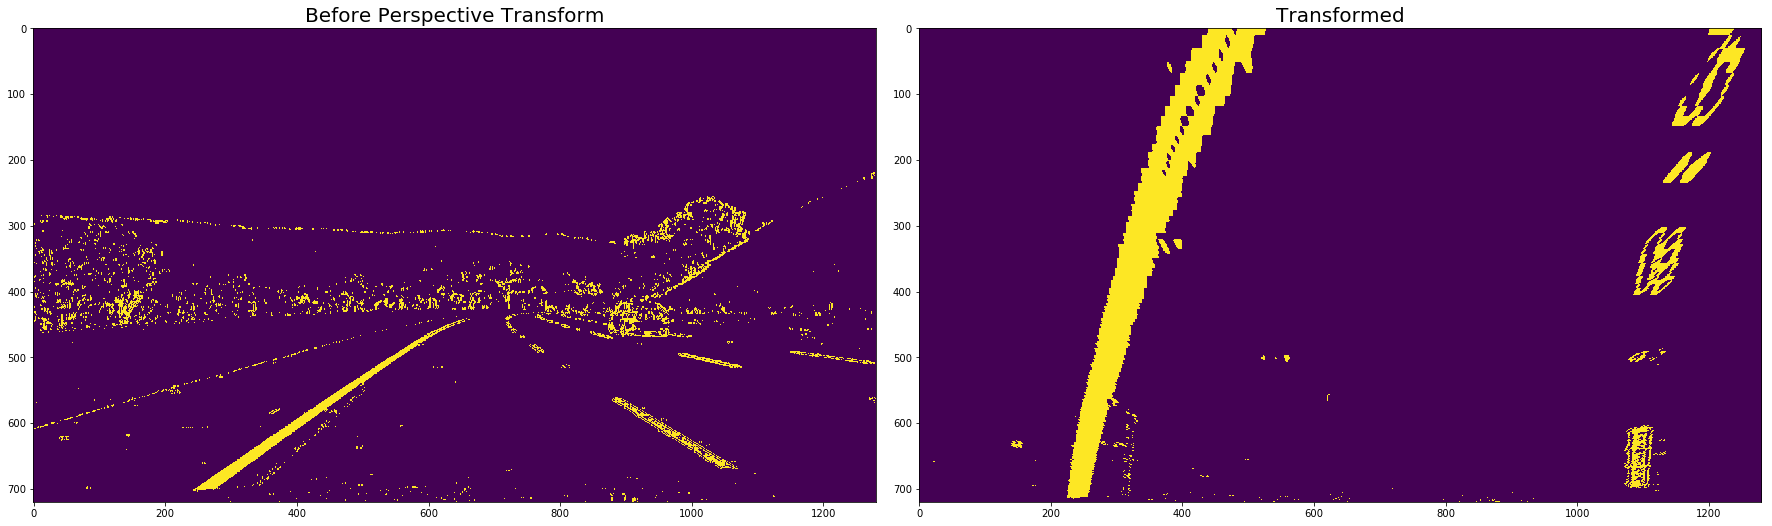

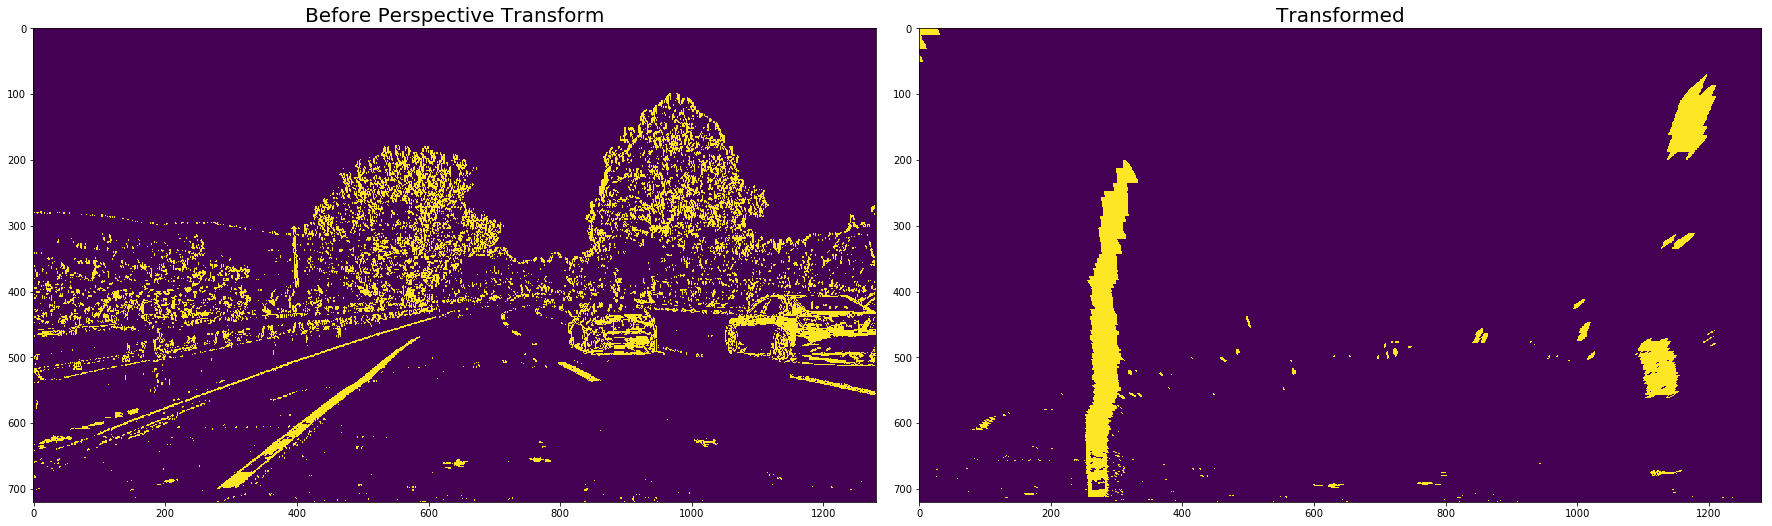

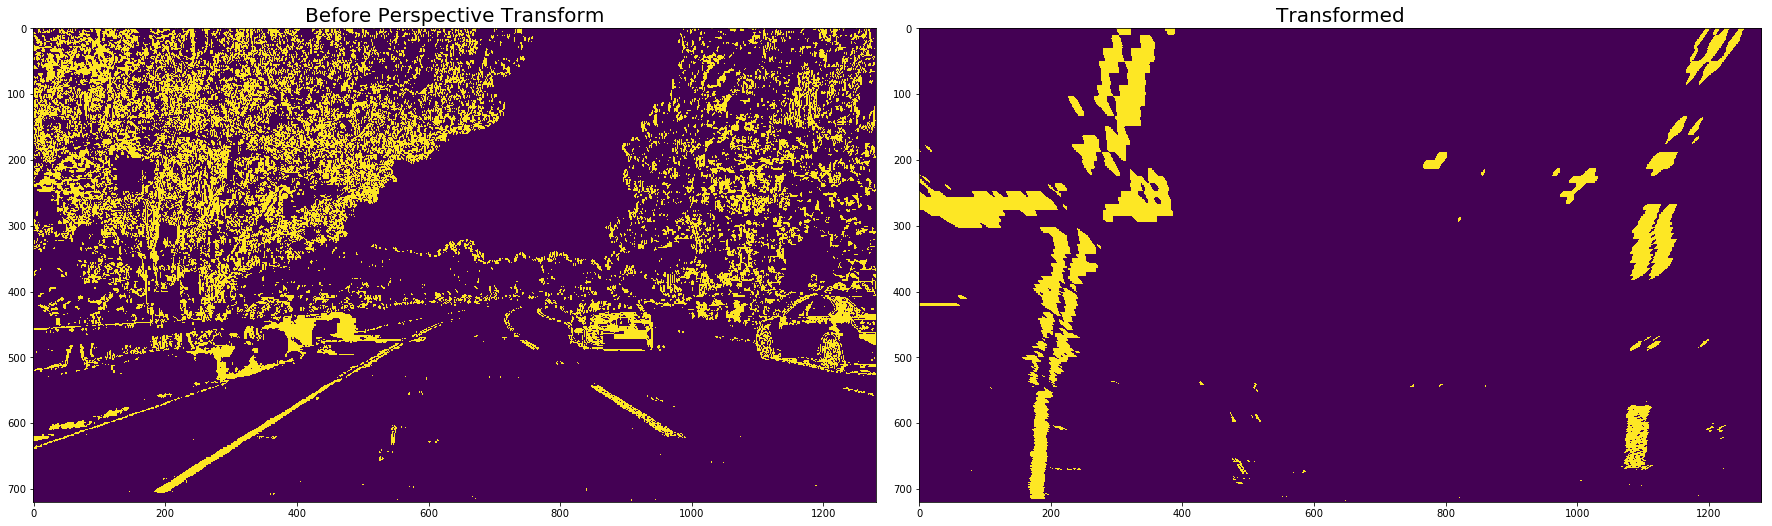

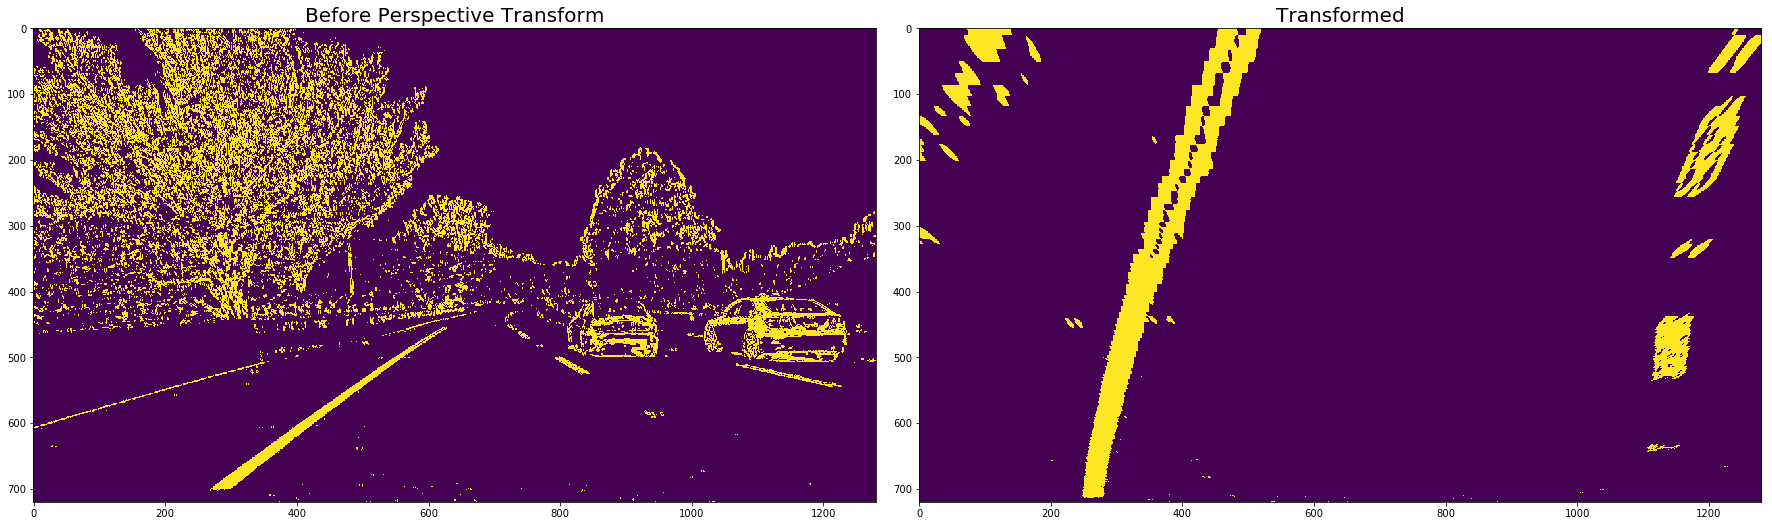

In [12]:
# Perspective transform
transformed = []
for img in color_gradient_results:
    warped = warp(img)
    transformed.append(warped)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Before Perspective Transform', fontsize=20)

    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [13]:
def pipeline(img):
    undst = undistort(img)
    clr_grad = color_gradient(undst)
    warped = warp(clr_grad)
    return warped

In [14]:
def sliding_window_fit(binary_warped):
    '''
    Fit lane lines by sliding windows
    '''
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangle_points = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangle_points.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    visualization = (rectangle_points, histogram)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization

(720, 0)

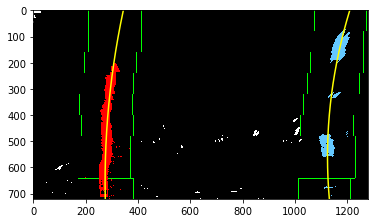

In [15]:
# Test on an example from test images
example_img = mpimg.imread('./test_images/test4.jpg')
example_img_bin = pipeline(example_img)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization = sliding_window_fit(example_img_bin)

rectangles = visualization[0]
histogram = visualization[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((example_img_bin, example_img_bin, example_img_bin))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, example_img_bin.shape[0]-1, example_img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rectangle in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img, (rectangle[2], rectangle[0]), (rectangle[3], rectangle[1]), (0,255,0), 2) 
    cv2.rectangle(out_img, (rectangle[4], rectangle[0]), (rectangle[5], rectangle[1]), (0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = example_img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
def fit_using_prev(binary_warped, left_fit_prev, right_fit_prev):
    '''
    Fit line using previous fit
    '''
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

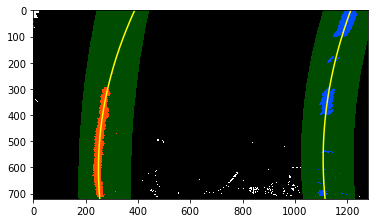

In [17]:
example_img2 = mpimg.imread('./test_images/test1.jpg')
example_img2_bin = pipeline(example_img2)   
margin = 100

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = fit_using_prev(example_img2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, example_img2_bin.shape[0]-1, example_img2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((example_img2_bin, example_img2_bin, example_img2_bin))*255)
window_img = np.zeros_like(out_img)

nonzero = example_img2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [18]:
def calc_radius(bin_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    '''
    Calculate radii of the curvatures and distance from center of the lane
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    height = bin_img.shape[0]
    ploty = np.linspace(0, height-1, height)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    
    # Calculate distance from center of lane 
    if right_fit is not None and left_fit is not None:
        car_pos = bin_img.shape[1]/2
        left_fit_pos = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_fit_pos = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
        lane_center_pos = (right_fit_pos + left_fit_pos) /2
        center_dist = (car_pos - lane_center_pos) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [19]:
left_curverad, right_curverad, center_dist = calc_radius(example_img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radii of curvatures:', left_curverad, 'm,', right_curverad, 'm')
print('Distance from lane center:', center_dist, 'm')

Radii of curvatures: 1010.80769657 m, 604.809804107 m
Distance from lane center: -0.335071598861 m


In [20]:
def draw_lane(original_img, binary_img, left_fit, right_fit, Minv = Minv):
    '''
    Project back on to the road
    '''
    if left_fit is None or right_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height = binary_img.shape[0]
    ploty = np.linspace(0, height -1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.5, 0)
    return result

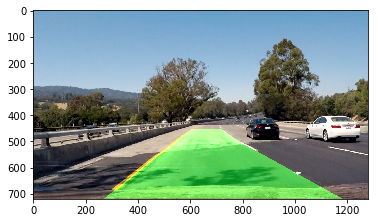

In [21]:
example_out1 = draw_lane(example_img, example_img_bin, left_fit, right_fit, Minv)
plt.imshow(example_out1)

In [22]:
def write_result(img, left_curverad, right_curverad, center_dist):
    '''
    Write measurements on the img
    '''
    font = cv2.FONT_HERSHEY_DUPLEX
    font_color = (255, 255, 155)
    cv2.putText(img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, 2, font_color, 2)
    cv2.putText(img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, 2, font_color, 2)
    cv2.putText(img, 'Vehicle is {:.2f} m of lane center'.format(center_dist), (50, 190), font, 2, font_color, 2)
    
    return img

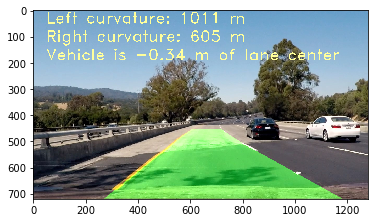

In [23]:
example_out2 = write_result(example_out1, left_curverad, right_curverad, center_dist)
plt.imshow(example_out2)

In [24]:
# Line object to keep track of parameters
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_fit(self, fit):
        if self.best_fit is not None:
            self.diffs = abs(fit-self.best_fit)
        # check if good fit
        if (self.diffs[0] > 0.01 or self.diffs[1] > 1.0 or self.diffs[2] > 100.0) and len(self.current_fit) > 0:
            self.detected = False
        else:
            self.detected = True
            
            self.current_fit.append(fit)

            if len(self.current_fit) > 10:
                # remove past fits, only keep latest 10
                self.current_fit = self.current_fit[len(self.current_fit)- 10:]
            self.best_fit = np.average(self.current_fit, axis=0)


In [25]:
def process_image(img):
    '''
    Big pipeline for the video
    '''
    img_bin = pipeline(img)
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_window_fit(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_using_prev(img_bin, left_line.best_fit, right_line.best_fit)

    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
    
    img_out = draw_lane(img, img_bin, left_line.best_fit, right_line.best_fit, Minv)
    left_radius, right_radius, center_dist = calc_radius(img_bin, left_line.best_fit, right_line.best_fit, left_lane_inds, right_lane_inds)
    out = write_result(img_out, left_radius, right_radius, center_dist)

    return out

In [26]:
left_line = Line()
right_line = Line()
process = process_image(example_img)

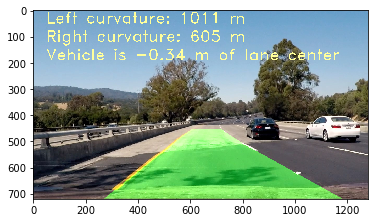

In [27]:
plt.imshow(process)

Apply to project video

In [28]:
from moviepy.editor import VideoFileClip

In [29]:
left_line = Line()
right_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:15<00:00,  5.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 17s
